#Jigsaw Unintended Bias in Toxicity Classification


## Description
Can you help detect toxic comments ― and minimize unintended model bias? That's your challenge in this competition.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

Last year, in the Toxic Comment Classification Challenge, you built multi-headed models to recognize toxicity and several subtypes of toxicity. This year's competition is a related challenge: building toxicity models that operate fairly across a diverse range of conversations.

Here’s the background: When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

In this competition, you're challenged to build a model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. You'll be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias. Develop strategies to reduce unintended bias in machine learning models, and you'll help the Conversation AI team, and the entire industry, build models that work well for a wide range of conversations.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

Acknowledgments
The Conversation AI team would like to thank Civil Comments for making this dataset available publicly and the Online Hate Index Research Project at D-Lab, University of California, Berkeley, whose labeling survey/instrument informed the dataset labeling. We'd also like to thank everyone who has contributed to Conversation AI's research, especially those who took part in our last competition, the success of which led to the creation of this challenge.


### 1. **Data Structure Overview**:
the data contains:
- Comment text.
- A fractional toxicity label (`target`), where values ≥ 0.5 can be binarized to indicate a toxic comment.
- Additional toxicity subtype attributes, which are not the main focus but can be used for auxiliary tasks or to augment the main task.
- Identity attributes, which indicate the identities mentioned in the comments.
- Metadata from both Jigsaw and Civil Comments.

### 2. **Data Preprocessing**:
#### 2.1 Comment Text:
Given a comment $ C $:
$$\text{Tokenize}(C) \rightarrow \{w_1, w_2, \dots, w_n\}$$
Where $ w_i $ is each word in the comment.

#### 2.2 Toxicity Binarization:
Given the toxicity label $ T $ for a comment:
$$ \text{IsToxic}(T) =
\begin{cases}
1 & \text{if } T \geq 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

#### 2.3 Identity Extraction:
For each identity attribute column $ I_i $, values should be extracted to use as features or for bias analysis.

### 3. **Exploratory Data Analysis (EDA)**:
#### 3.1 Distribution Analysis:
Plot histograms to visualize the distribution of:
- `target` values.
- Each identity attribute.
- Each toxicity subtype.

#### 3.2 Correlation Analysis:
Determine if there are any strong correlations between certain identity mentions and the `target` label, which can signal potential biases.

### 4. **Feature Engineering**:
#### 4.1 Text Vectorization:
Convert `comment_text` into vectors using Keras


### 5. **Model Development**:
Given the multi-dimensionality of the data (toxicity, subtypes, identity mentions), we will consider using deep learning architectures such as:
- Convolutional Neural Networks (CNN) for text.
- Recurrent Neural Networks (RNN) like LSTM or GRU.
- Transformer-based models.

**For now we built a RNN model using LSTM

### 6. **Bias Mitigation**:
Given the core challenge, focus on:
- **Re-weighting**: Assign higher weights to under-represented identity mentions during training.
- **Bias Detection in Hidden Layers**: Analyze the activations in hidden layers to detect any patterns that consistently activate for specific identity mentions.

### 7. **Model Evaluation**:
Beyond standard metrics (accuracy, precision, recall, F1-score), introduce a custom metric that measures unintended bias. For instance, the difference in false positive rates between comments with and without identity mentions.

### 8. **Post-processing for Bias Mitigation**:


### 9. **Deployment and Feedback Loop**:
Deploy the model in a real-world scenario, ensure a feedback mechanism is in place to refine and retrain the model, especially focusing on cases where bias might be present.

### 10. **Ethical Considerations**:
- Given the sensitivity of the data, ensure that the data is handled with utmost confidentiality.
- Ensure model decisions can be explained, and the model does not perpetrate or amplify existing societal biases.





In [1]:
!pip install keras-tuner

In [2]:
!pip install neattext

In [4]:
import pandas as pd
import numpy as np
import collections

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import keras_tuner


import nltk
import spacy
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')
import neattext as nt
import neattext.functions as nfx
import re

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend


<ipython-input-4-01da7a222f36>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
train_data = pd.read_csv("PATH")

<Figure size 1000x600 with 0 Axes>

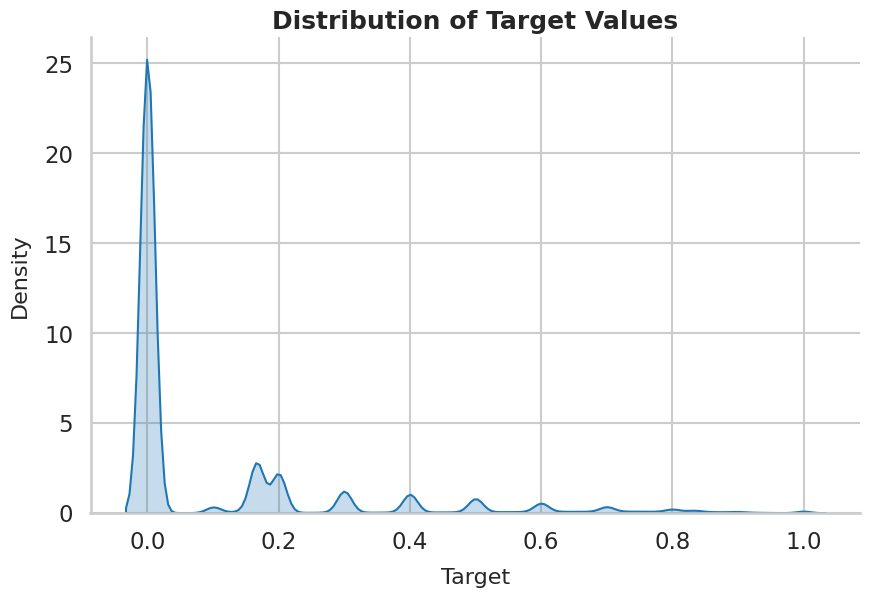

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and context for the plot
sns.set_style("whitegrid")
sns.set_context("talk")  # "talk" context is suited for presentations

# Create the plot
plt.figure(figsize=(10, 6))
plot = sns.displot(data=train_data, x='target', kind='kde', fill=True, height=6, aspect=1.5)
plot.ax.set_title('Distribution of Target Values', fontsize=18, fontweight='bold')
plot.set_axis_labels('Target', 'Density', fontsize=16)
plot.ax.xaxis.labelpad = 10
plot.ax.yaxis.labelpad = 10

# Display the plot
plt.show()


In [8]:
target = []
train_data['target'].apply(lambda x : target.append('Toxic comment') if x >= 0.5 else target.append('Not toxic comment'))

0          None
1          None
2          None
3          None
4          None
           ... 
1804869    None
1804870    None
1804871    None
1804872    None
1804873    None
Name: target, Length: 1804874, dtype: object

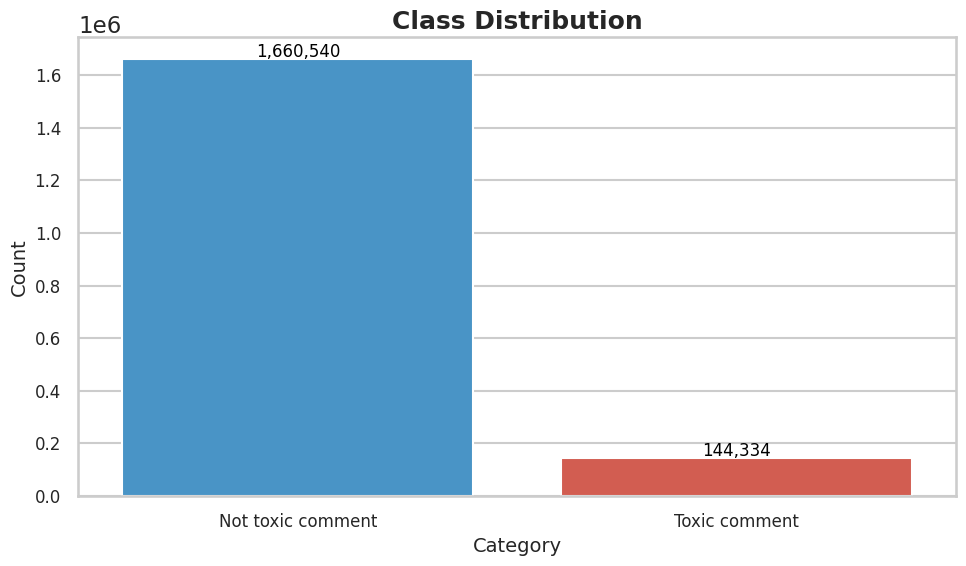

In [9]:
elements_count = collections.Counter(target)

# Convert dictionary to DataFrame
df = pd.DataFrame(list(elements_count.items()), columns=['Element', 'Count'])

# Set style for the plot
sns.set_style("whitegrid")
sns.set_context("talk")  # "talk" context is suited for presentations

# Create a color palette to distinguish categories
palette = ["#3498db" if label == "Not toxic comment" else "#e74c3c" for label in df['Element']]

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Element', y='Count', data=df, palette=palette)

# Display the count above each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height()):,}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     fontsize=12, color='black',
                     xytext=(0, 5),
                     textcoords='offset points')

# Set the title and axis labels
plt.title('Class Distribution', fontsize=18, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


We can see the class imbalance that we have to deal with

In [10]:
round(train_data.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
id,1804874.0,3738433.791,2445186.763,59848.0,796975.25,5223774.5,5769854.500,6334010.00
target,1804874.0,0.103,0.197,0.0,0.00,0.0,0.167,1.00
severe_toxicity,1804874.0,0.005,0.023,0.0,0.00,0.0,0.000,1.00
obscene,1804874.0,0.014,0.065,0.0,0.00,0.0,0.000,1.00
identity_attack,1804874.0,0.023,0.079,0.0,0.00,0.0,0.000,1.00
insult,1804874.0,0.081,0.176,0.0,0.00,0.0,0.091,1.00
threat,1804874.0,0.009,0.049,0.0,0.00,0.0,0.000,1.00
asian,405130.0,0.012,0.087,0.0,0.00,0.0,0.000,1.00
atheist,405130.0,0.003,0.050,0.0,0.00,0.0,0.000,1.00
bisexual,405130.0,0.002,0.026,0.0,0.00,0.0,0.000,1.00


In [11]:
train_data['label_class'] = train_data['target'].apply(lambda x : 1 if x >= 0.5 else 0)
train_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,label_class
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,1


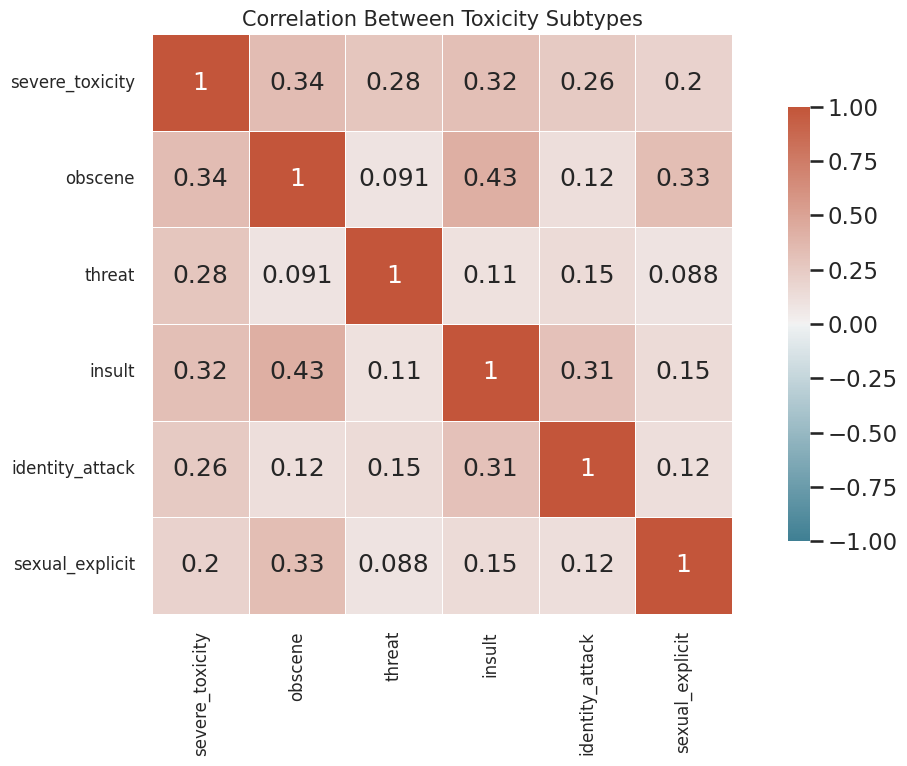

In [12]:
toxicity_subtypes = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
correlation_matrix = train_data[toxicity_subtypes].corr()

# Styling and plotting
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Setting a diverging color palette
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1,
            linewidths=.5, cbar_kws={"shrink": 0.75}, square=True)

# Setting title and adjusting layout
plt.title('Correlation Between Toxicity Subtypes', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()

plt.show()


### Let's delve into our text

In [13]:
train_data, _ = train_test_split(train_data, train_size=0.1, stratify=train_data['label_class'])
train_data = train_data.reset_index()
train_data

,index,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,label_class
0,876157,5192740,0.0,"Thank you, Alexandra!",0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,0,6,0,0.0,0,4,0
1,1011730,5354796,0.0,I'm neither a gun owner nor a gun advocate. I ...,0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,1,2,0,0.0,0,4,0
2,1057197,5409200,0.0,"So, all a company has to do is sell its debt, ...",0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,0,0,0,0.0,0,4,0
3,1267182,5663573,0.0,"targeting? come on, this maui deputy prosecut...",0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,0,1,0,0.0,0,4,0
4,821481,5126100,0.0,"""... that the Harper government handled better...",0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,0,0,0,0.0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180482,473516,824764,0.5,"""Unqualified lightweights"" and ""billionaire"" d...",0.0,0.0,0.0,0.5,0.0,NaN,...,approved,0,1,0,8,0,0.0,0,10,1
180483,365950,691207,0.0,He has worked within the business environment ...,0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,0,1,0,0.0,0,4,0
180484,1496385,5951893,0.0,I don't really understand why this article was...,0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,0,0,0,0.0,0,4,0
180485,190188,473729,0.0,"Ahhh, ballot stuffing.....the way democrats ge...",0.0,0.0,0.0,0.0,0.0,NaN,...,approved,0,0,0,9,0,0.0,0,4,0


In [15]:
train_data['label_class'].value_counts()

0    166054
1     14433
Name: label_class, dtype: int64

In [16]:
data_text = train_data[['comment_text', 'label_class']]
data_text['len'] = data_text['comment_text'].apply(lambda x : len(x.split()))
data_text

<ipython-input-16-bc5673f3f62b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text['len'] = data_text['comment_text'].apply(lambda x : len(x.split()))


,comment_text,label_class,len
0,"Thank you, Alexandra!",0,3
1,I'm neither a gun owner nor a gun advocate. I ...,0,50
2,"So, all a company has to do is sell its debt, ...",0,20
3,"targeting? come on, this maui deputy prosecut...",0,67
4,"""... that the Harper government handled better...",0,78
...,...,...,...
180482,"""Unqualified lightweights"" and ""billionaire"" d...",1,58
180483,He has worked within the business environment ...,0,55
180484,I don't really understand why this article was...,0,41
180485,"Ahhh, ballot stuffing.....the way democrats ge...",0,13


In [17]:
def remove_outliers(df, column_name, multiplier=1.5):
    """
    Remove outliers from a dataframe using IQR.

    Parameters:
    - df : DataFrame
    - column_name : str : Name of the column from which outliers should be filtered.
    - multiplier : float : Multiplier for the IQR. Default is 1.5.

    Returns:
    - DataFrame : Filtered dataframe with outliers removed.
    """

    # Calculate Q1, Q2 and IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter the data
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return filtered_df

# Usage
filtered_df = remove_outliers(data_text, 'len')
filtered_df

,comment_text,label_class,len
0,"Thank you, Alexandra!",0,3
1,I'm neither a gun owner nor a gun advocate. I ...,0,50
2,"So, all a company has to do is sell its debt, ...",0,20
3,"targeting? come on, this maui deputy prosecut...",0,67
4,"""... that the Harper government handled better...",0,78
...,...,...,...
180482,"""Unqualified lightweights"" and ""billionaire"" d...",1,58
180483,He has worked within the business environment ...,0,55
180484,I don't really understand why this article was...,0,41
180485,"Ahhh, ballot stuffing.....the way democrats ge...",0,13


In [18]:
filtered_df['len'].describe()

count    170659.000000
mean         44.422673
std          37.329438
min           1.000000
25%          16.000000
50%          33.000000
75%          63.000000
max         156.000000
Name: len, dtype: float64

In [38]:
args = {}

def process_texts(texts, nlp, args={}):
    """
    Processes a batch of texts by applying a series of transformations.

    Parameters:
    ----------
    texts : list of str
        A list of input strings that require processing. Each string should be a coherent
        piece of text, which may consist of multiple sentences.
    nlp : SpaCy Language object
        The SpaCy model used for tokenization.
    args : dict
        A dictionary containing additional information, such as stop words.

    Returns:
    -------
    list of str
        A list of processed versions of the input texts with transformations applied.
    """
    docs = list(nlp.pipe(texts))
    processed_texts = []

    for doc in docs:
        tokens = [token.lemma_.lower() for token in doc if not token.like_email and not token.like_url
                  and not token.like_num and not token.is_punct and token.text.lower() not in args.get('stop_words', [])]
        processed_texts.append(" ".join(tokens))

    return processed_texts

def define_stopwords(docs):
    """
    Derives a list of stop words based on the frequency of words across the provided documents.

    This function analyzes the input documents to identify frequently occurring words.
    The rationale is that words with high frequency across multiple documents may
    often be considered as stop words, as they might offer limited informational value
    for certain analytical tasks.

    Parameters:
    ----------
    docs : list of str
        A collection of textual documents. Each document is represented as a
        string within this list.

    Returns:
    -------
    list of str
        A list containing words determined to be stop words based on their
        frequency across the provided documents.
    """

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(docs)

    # Summing directly on the sparse matrix
    word_freqs = X.sum(axis=0)
    word_freqs = word_freqs.A1  # Convert matrix to 1D numpy array

    # Combine words and their frequencies in a dictionary and sort them
    freq_dict = dict(zip(vectorizer.get_feature_names_out(), word_freqs))
    sorted_freqs = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))

    threshold = 100000
    stop_words = [word.lower() for word, freq in sorted_freqs.items() if freq > 5000]

    return stop_words

args['stop_words'] = define_stopwords(filtered_df['comment_text'])

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
texts = filtered_df['comment_text'].tolist()
processed_texts = process_texts(texts, nlp, args)


In [41]:
# with open('/content/drive/MyDrive/data scienece AI/PROJECTS/Jigsaw Unintended Bias in Toxicity Classification/processed_text.txt', 'w') as f:
#     for text in processed_texts:
#         f.write("%s\n" % text)
df = pd.DataFrame(processed_texts, columns=['ProcessedText'])
df.to_csv('/content/drive/MyDrive/data scienece AI/PROJECTS/Jigsaw Unintended Bias in Toxicity Classification/processed_text.csv')

In [34]:
# # Initialize an empty list to store the lines
# processed_texts = []

# # Open the file for reading
# with open('/content/drive/MyDrive/data scienece AI/PROJECTS/Jigsaw Unintended Bias in Toxicity Classification/processed_text.txt', 'r') as f:
#     # Loop through each line in the file
#     for line in f:
#         # Strip removes any leading and trailing whitespaces (including the newline character)
#         processed_texts.append(line)

# # Now, processed_texts contains all lines from the text file as elements in a list

## Model Building

### building the vectorizing layer

In [42]:
MAX_FEATURES = 20000
EMBEDDING_DIM = 128
SEQUENCE_LENGTH = 250


vectorizer_layer = TextVectorization(
    max_tokens = MAX_FEATURES,
    output_mode = "int",
    output_sequence_length = SEQUENCE_LENGTH
)

vectorizer_layer.adapt(processed_texts)

In [43]:
X_train = np.array(processed_texts)

In [44]:
X_train.shape

(170659,)

### One hot the labels

In [45]:
labels_encoder = tf.keras.layers.CategoryEncoding(
    num_tokens = 2,
    output_mode='one_hot'
)

y_train = np.array(labels_encoder(filtered_df['label_class']))
y_train.shape

(170659, 2)

### Building the model and performing hyperparameters tuning

In [48]:
class TextModel(tf.keras.Model):
    """
    TextModel is a subclass of tf.keras.Model designed for text classification tasks. 
    The architecture comprises multiple layers including LSTM, Dense, and a Softmax layer for output.
    
    Attributes:
    ----------
    lstm_units : list of int
        List containing the number of LSTM units for each LSTM layer.
        
    dense_units : list of int
        List containing the number of units for each Dense layer.
        
    num_classes : int
        The number of output classes for classification.

    Methods:
    -------
    call(inputs)
        Defines the forward pass for the model.
    """"

    def __init__(self, lstm_units=[], dense_units=[], num_classes=2, **kwargs):
        """
        Initializes the TextModel object with the specified architecture.

        Parameters:
        ----------
        lstm_units : list of int
            Number of LSTM units for each LSTM layer.
            
        dense_units : list of int
            Number of dense units for each Dense layer.
            
        num_classes : int, optional
            Number of output classes, default is 2.
        """
        super(TextModel, self).__init__(**kwargs)

        # Hyperparameters
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.num_classes = num_classes

        self.input_layer = tf.keras.Input(shape=(None, ), dtype=tf.string, name='text')
        self.vectorizer_layer = vectorizer_layer
        self.embedding_layer = tf.keras.layers.Embedding(MAX_FEATURES + 1, EMBEDDING_DIM)
        self.hidden_layer_1 = tf.keras.layers.LSTM(units=self.lstm_units[0], activation='tanh', return_sequences=True)
        self.hidden_layer_2 = tf.keras.layers.LSTM(units = self.lstm_units[1], activation='tanh')
        self.dense_1 = tf.keras.layers.Dense(units = self.dense_units[0], activation='relu')
        self.dense_2 = tf.keras.layers.Dense(units = self.dense_units[1], activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=self.num_classes, activation='softmax')


    def call(self, inputs):
        """
        Defines the forward pass for the model.
        
        Parameters:
        ----------
        inputs : tf.Tensor
            Tensor representing the input text data.

        Returns:
        -------
        tf.Tensor
            Output tensor after passing through the model layers.
        """
        x = self.vectorizer_layer(inputs)
        x = self.embedding_layer(x)
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.output_layer(x)


def build_model(hp):
    """
    Constructs and compiles the TextModel based on the hyperparameters provided.
    
    Parameters:
    ----------
    hp : HyperParameters object
        Object containing ranges and values for different hyperparameters.

    Returns:
    -------
    TextModel object
        A compiled TextModel object.
    """
    lstm_units = [hp.Int('lstm_units_1', min_value=32, max_value=256, step=32), hp.Int('lstm_units_2', min_value=32, max_value=256, step=32)]
    dense_units = [hp.Int('dense_units_1', min_value=32, max_value=512, step=32), hp.Int('dense_units_2', min_value=32, max_value=512, step=32)]
    model = TextModel(lstm_units, dense_units)
    model.build((None,))

    model.compile(
      optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
      loss='categorical_crossentropy',
      metrics=[
        'accuracy',
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
      ]
    )

    return model



# Create a HyperParameters object
hp = HyperParameters()
# Create the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=3,
    directory='random_search',
    project_name='text_model',
    overwrite=True
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=2, validation_split=0.2)

Trial 1 Complete [00h 14m 35s]
val_accuracy: 0.9190788865089417

Best val_accuracy So Far: 0.9190788865089417
Total elapsed time: 00h 14m 35s


In [51]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get individual hyperparameters
best_lstm_units_1 = best_hps.get('lstm_units_1')
best_lstm_units_2 = best_hps.get('lstm_units_2')
best_dense_units_1 = best_hps.get('dense_units_1')
best_dense_units_2 = best_hps.get('dense_units_2')
best_learning_rate = best_hps.get('learning_rate')

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_lstm_units_1},
the optimal number of units in the second LSTM layer is {best_lstm_units_2},
the optimal number of units in the first Dense layer is {best_dense_units_1},
the optimal number of units in the second Dense layer is {best_dense_units_2},
and the optimal learning rate for the optimizer is {best_learning_rate}.
""")

model = TextModel(lstm_units=[best_lstm_units_1, best_lstm_units_2], dense_units=[best_dense_units_1, best_dense_units_2])
model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
      loss='categorical_crossentropy',
      metrics=[
        'accuracy',
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
      ]
    )

model.fit(X_train, y_train, epochs=5, validation_split=0.2)


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 224, 
the optimal number of units in the second LSTM layer is 64,
the optimal number of units in the first Dense layer is 384,
the optimal number of units in the second Dense layer is 384,
and the optimal learning rate for the optimizer is 0.0001.

Epoch 1/5
4267/4267 [==============================] - 169s 38ms/step - loss: 0.2848 - accuracy: 0.9186 - tp: 125417.0000 - tn: 125417.0000 - fp: 11110.0000 - fn: 11110.0000 - precision: 0.9186 - recall: 0.9186 - val_loss: 0.2828 - val_accuracy: 0.9191 - val_tp: 31370.0000 - val_tn: 31370.0000 - val_fp: 2762.0000 - val_fn: 2762.0000 - val_precision: 0.9191 - val_recall: 0.9191
Epoch 2/5
4267/4267 [==============================] - 114s 27ms/step - loss: 0.2822 - accuracy: 0.9188 - tp: 125443.0000 - tn: 125443.0000 - fp: 11084.0000 - fn: 11084.0000 - precision: 0.9188 - recall: 0.9188 - val_loss: 0.2812 - val_accuracy: 0.9191 - val_tp: 31370.0000 - 

In [54]:
model.save('PATH', save_format='tf')

In [55]:
from tensorflow.keras.models import load_model

loaded_model = load_model("PATH")
loaded_model.summary()

Model: "text_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  multiple                  0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     multiple                  2560128   
                                                                 
 lstm_2 (LSTM)               multiple                  316288    
                                                                 
 lstm_3 (LSTM)               multiple                  73984     
                                                                 
 dense_3 (Dense)             multiple                  24960     
                                                                 
 dense_4 (Dense)             multiple                  147840    
                                                      

# Updates will come soon